In [1]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
import os,sys,datetime
import seaborn as sns
import networkx as nx

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from dkl_explore import get_internals, gauss_DV, power_law ,components

from matplotlib.colors import LogNorm

**Let's select the parameter space**

In [ ]:
# Resolution
res = 40

# Repeat runs
rep = 5

# Pruning parameters
beta = np.linspace(0.001, 5, res)

# Separation parameter
dist = np.linspace(0, 5, res)

# Set uncertainty on new observations
varc = 10

# Get dimensional d
d_norm = dist[:]/np.sqrt(varc)

# Set number of agents
N = 100

# Where to store values
sv_pth = './b[' + str(beta[0]) + ',' + str(beta[-1]) + ']d[' + str(dist[0]) + ',' + str(dist[-1]) + ']/'

titles = ['$D(0)$','$\\sigma_{D(0)}$',
          '$D(T)$','$\\sigma_{D(T)}$',
          'Strongly Connected Components','$\\sigma_{SCC}$',
          'Weakly Connected Components','$\\sigma_{WCC}$',
          'Assortativity','$\\sigma_{a}$',
          'Transitivity','$\\sigma_{t}$']

**Print $D_{KL}$ values from saved data and save picture**

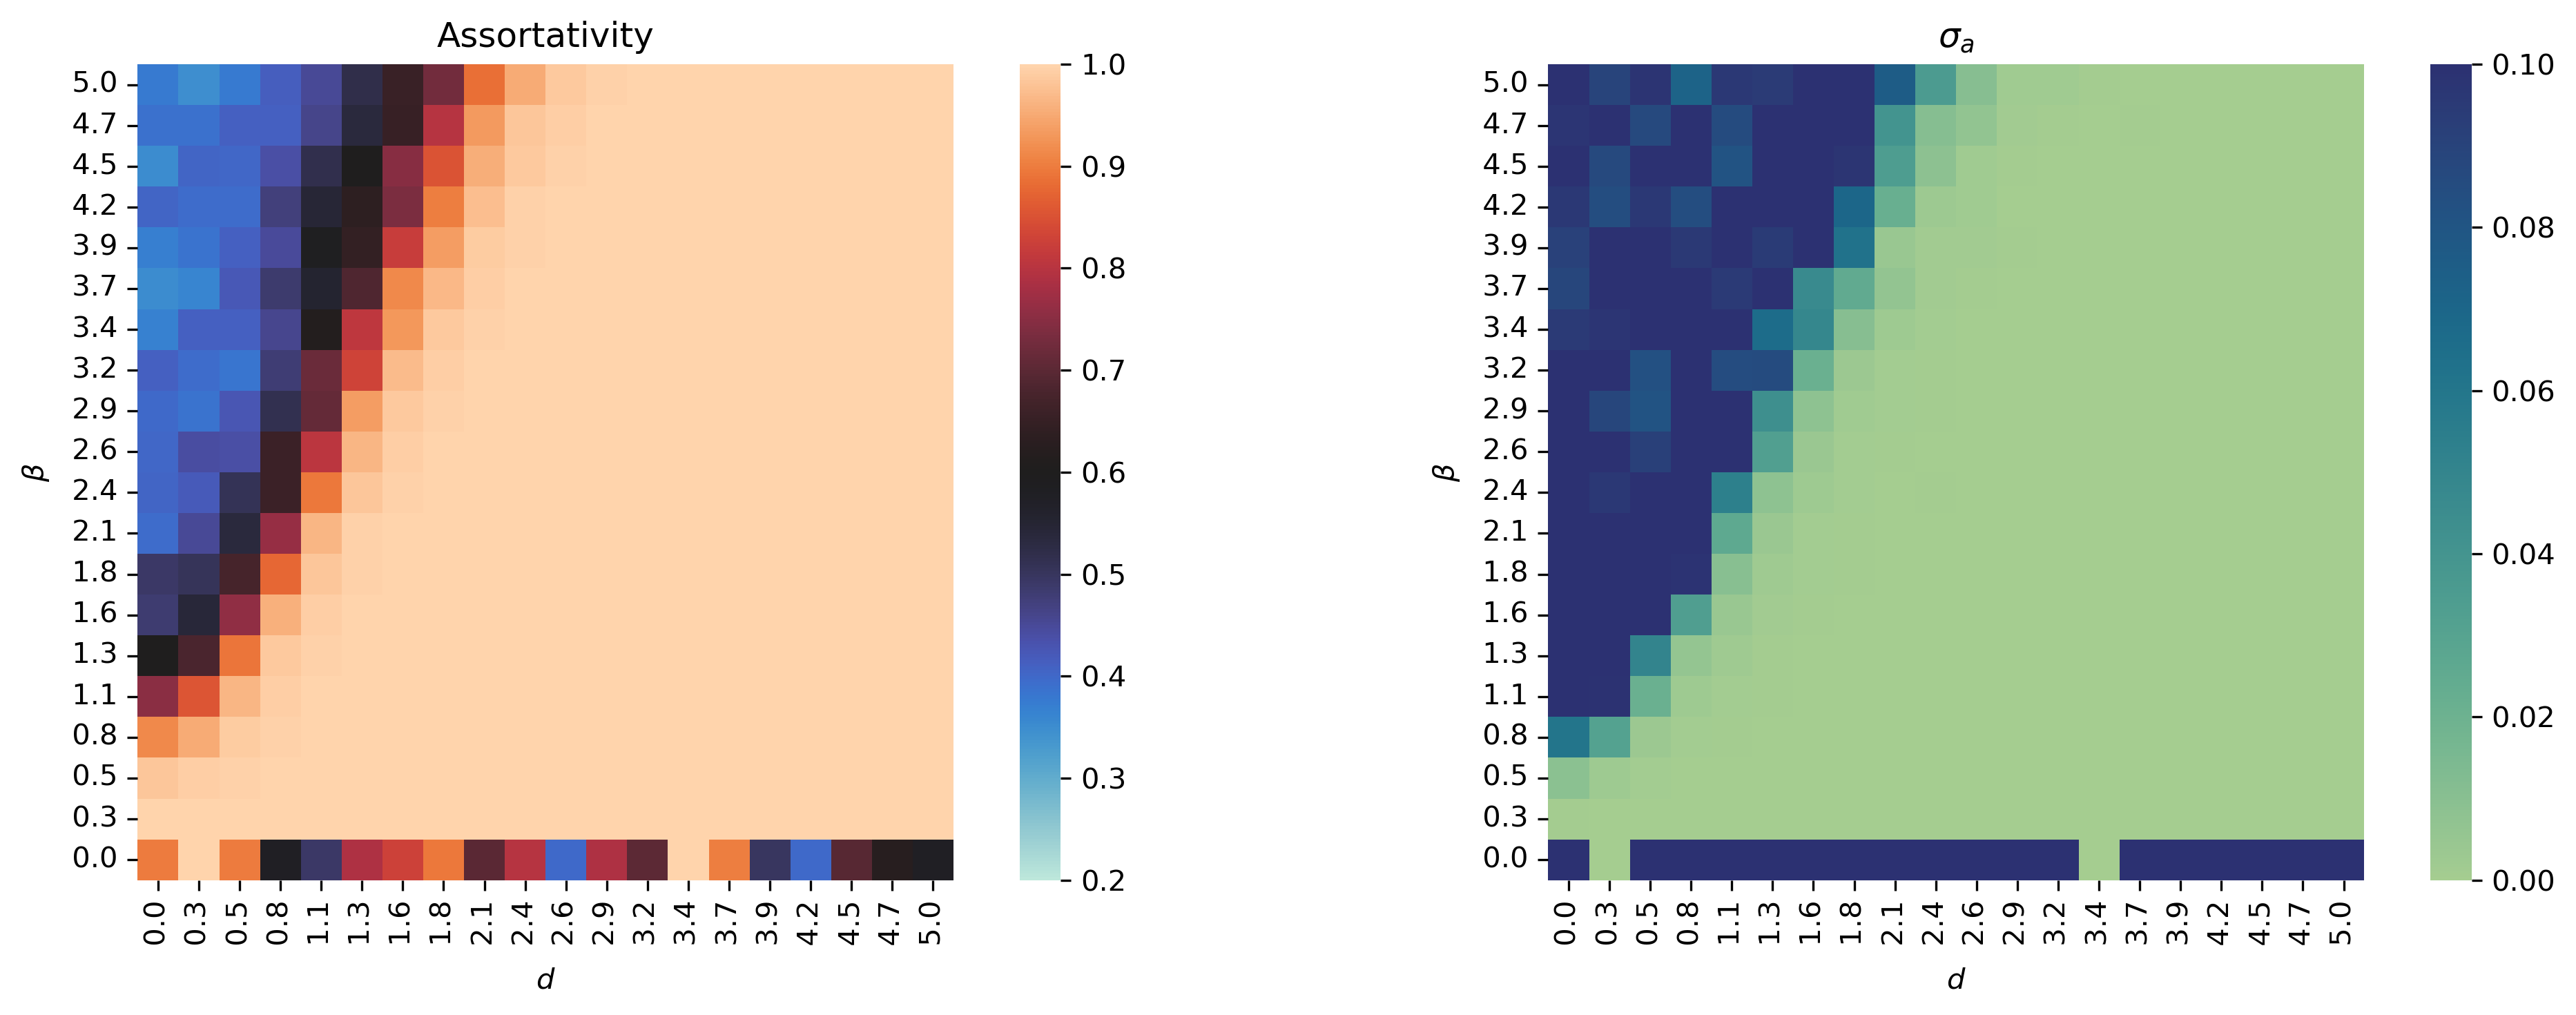

In [14]:
# Load saved arrays
TOT = np.load(sv_pth + str(N) + '_' + str(res) + 'ps.npy').reshape((res,res,6,rep))

c = 4

# Get labels for graphics
b_st = []
for b in beta:

    b_st.append(f'{b: 0,.1f}')

d_st = []
for dis in dist:

    d_st.append(f'{dis: 0,.1f}')

# Print phase space
fig, ax = plt.subplots(1,2, figsize = (14,5), dpi = 300)

# DV0
if c == 0:

    sns.heatmap(np.nanmean(TOT[:,:,c,:], axis = -1), norm = LogNorm(vmax = 50), square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0])
    sns.heatmap(np.nanstd(TOT[:,:,c,:], axis = -1), vmin = 0, vmax = 1, square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[1])

# DV
elif c == 1:

    sns.heatmap(np.nanmean(TOT[:,:,c,:], axis = -1), norm = LogNorm(vmax = 50), square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0])
    sns.heatmap(np.nanstd(TOT[:,:,c,:], axis = -1), vmin = 0, vmax = 10, square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[1])

# SCC
elif c == 2:

    sns.heatmap(np.nanmean(TOT[:,:,c,:], axis = -1), norm = LogNorm(vmax = N), square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0])
    sns.heatmap(np.nanstd(TOT[:,:,c,:], axis = -1), vmin = 0, vmax = 0.1*N, square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[1])

# WCC
elif c == 3:

    sns.heatmap(np.nanmean(TOT[:,:,c,:], axis = -1), norm = LogNorm(vmax = N), square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0])
    sns.heatmap(np.nanstd(TOT[:,:,c,:], axis = -1), vmin = 0, vmax = 0.1*N, square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[1])

# Ass
elif c == 4:

    sns.heatmap(np.nanmean(TOT[:,:,c,:], axis = -1), vmin = 0.2, vmax = 1, square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0])
    sns.heatmap(np.nanstd(TOT[:,:,c,:], axis = -1), vmin = 0, vmax = 0.1, square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[1])

# Trans
elif c == 5:

    sns.heatmap(np.nanmean(TOT[:,:,c,:], axis = -1), norm = LogNorm(vmax = 0.5), square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0])
    sns.heatmap(np.nanstd(TOT[:,:,c,:], axis = -1), vmin = 0, vmax = 0.1, square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[1])

ax[0].set_title(titles[2*c])
ax[1].set_title(titles[2*c + 1])

for a in ax:

    a.invert_yaxis()

    a.set_xlabel('$d$')
    a.set_ylabel('$\\beta$')

#fig.suptitle('Simulation phase space for $N = $' + str(N) + ' agents after $T = 60$')

plt.tight_layout()

plt.savefig(sv_pth + str(c) + '_' + str(N) + '_' + str(res) + '.png', dpi = 300)
plt.show()

**Simulate single pixels**

In [1]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
import os,sys,datetime
import seaborn as sns

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from dkl_explore import get_internals, gauss_DV, power_law, components

from scipy.stats import norm
from multiprocessing import Pool

from matplotlib.colors import LogNorm

In [7]:
# Select parameters

# Number of agents
Na = 100
# Number of out degrees in node initialization
friends = int(np.log(Na) + 0.5)
# Pruning parameter
b = 1000
# Initial separation of beliefs
d = 1
# Uncertainty on new observation
var_c = 10

# Variance of initial sampling distributions
vartrue = 1

# Duration
t = 60

# Number of simulations
Ns = 5

# Initialize results array
mus = np.empty((0,t+1,Na))
sigmas = mus
nets = []

for i in tqdm(range(0,Ns), desc = 'Running multiple simulations' , leave = True):
    mu, sigma, net = get_internals(N = Na, beta = b,
                    dist = d, var_c = var_c, T = t)
    
    mus = np.concatenate((mus, np.asarray(mu)[np.newaxis,:,:]), axis = 0)
    sigmas = np.concatenate((sigmas, np.asarray(sigma)[np.newaxis,:,:]), axis = 0)

    nets = nets + [net]

print('Done!')

Running multiple simulations: 100%|██████████| 5/5 [00:19<00:00,  3.91s/it]

Done!


**Calculate $D_{KL}$ for the new runs**

In [8]:
# Compute Divergence time series

# Initialize
DVts = np.empty((0,t+1))

# Set bins for discretization
n_bins = 10

# Compute
for i, mu in enumerate(mus):
    dv = []
    mu0 = mu[0]
    for j, x in enumerate(mu):

        dv.append(gauss_DV(x = x, m = x.mean(), d = power_law(j, dist = mu[0].std()), nbins = n_bins))
    
    DVts = np.concatenate((DVts, np.asarray(dv)[np.newaxis,:]), axis = 0)

**Calculate strongly and weakly connected components for new runs**

In [10]:
# Initialize result parameters
SCCts = np.empty((0,t+1))
WCCts = np.empty((0,t+1))

ts = [i for i in range(0,t+1)]

# Set multiprocessing parameters
workers = 1
chunksize = 1

# Loop over repeat runs
for i, n in enumerate(nets):

    # Create iterable function
    def it_components(t: int):
        scc, wcc = components(net = n[t], mus = mus[i,t,:], sigmas = sigmas[i,t,:], beta = b)
        return scc, wcc

    # Run multiprocessing over one run
    if __name__ == '__main__':
        with Pool(workers) as p:
            results = list(tqdm(p.imap(it_components, ts, chunksize = chunksize),  
                        
                        desc='Solving simulation ' + str(i+1),               
                        total=len(ts),
                        leave=True)
            )
            
            S = []
            W = []

            for r in results:

                S.append(r[0])
                W.append(r[1])

            S = np.asarray(S)
            W = np.asarray(W)
                
    SCCts = np.concatenate((SCCts, S[np.newaxis,:]), axis = 0)
    WCCts = np.concatenate((WCCts, W[np.newaxis,:]), axis = 0)

print('Done!')

Solving simulation 1:   0%|          | 0/61 [00:00<?, ?it/s]

Solving simulation 5: 100%|██████████| 61/61 [00:00<00:00, 180.50it/s]

Done!


**Have a LOOK at it!**

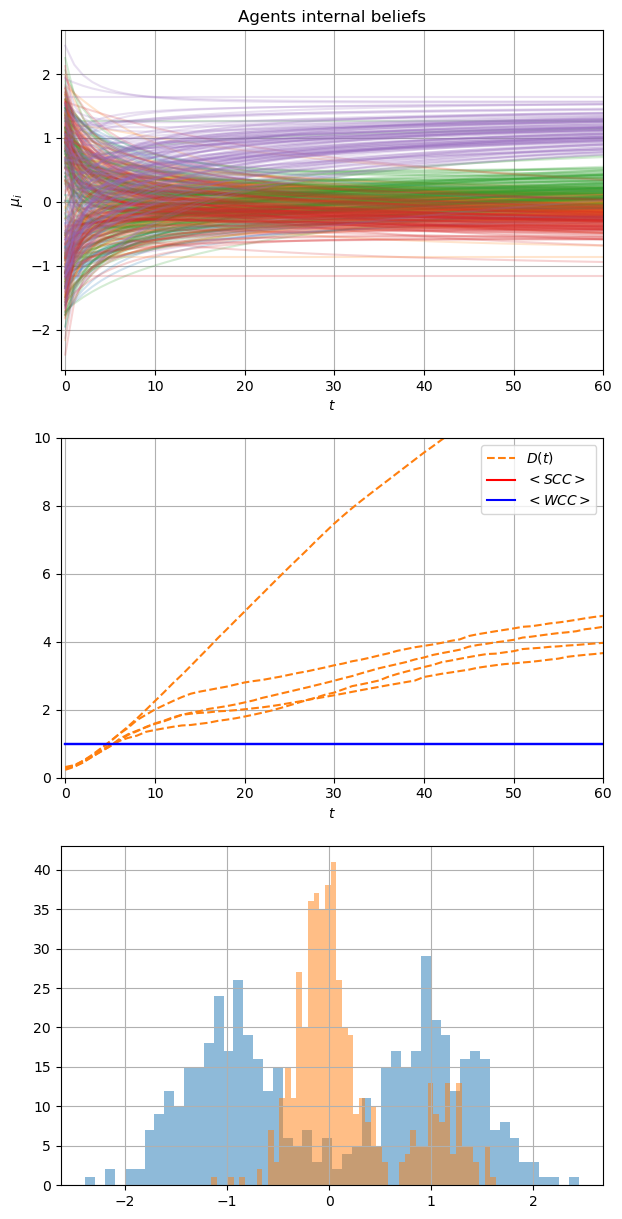

In [ ]:
# Show the internal beliefs of agents

fig, axs = plt.subplots(3,1, figsize = (7,15))

for ax in axs:

    ax.grid(True)

    if ax != axs[2]:
        ax.set_xlabel('$t$')
        ax.set_xlim(-0.5,t)

# Plot agent beliefs (Yes, all of them)
for i, mu in enumerate(mus):
    axs[0].plot(mu, 'C' + str(i) + '-', alpha = 0.2)

axs[0].set_ylabel('$\\mu_{i}$')
axs[0].set_title('Agents internal beliefs')

# Compare Divergence values
for i, dv in enumerate(DVts):
    if i == 0:
        axs[1].plot(dv, '--',  color = 'C1', label = '$D(t)$')
    else:
        axs[1].plot(dv, '--',  color = 'C1')

# Compare strongly connected components
for i, s in enumerate(SCCts):
    if i == 0:
        axs[1].plot(s, '-',  color = 'r', label = '$<SCC>$')
    else:
        axs[1].plot(s, '-',  color = 'r')

# Compare weakly connected components
for i, s in enumerate(WCCts):
    if i == 0:
        axs[1].plot(s, '-',  color = 'b', label = '$<WCC>$')
    else:
        axs[1].plot(s, '-',  color = 'b')


# Compare gaussian variance estimation
#for i, s in enumerate(mus.var(axis = 2)):
#    axs[1].plot(s, '-',  color = 'C' + str(i), label = '$<\\sigma^{2}>($' + str(i) + ')')

# Compare average agent variances (Kinda useless but it.s here)
#for i, s in enumerate(sigmas.mean(axis = 2)):
#    axs[1].plot(s, '-',  color = 'C' + str(i), label = '$<\\sigma^{2}>($' + str(i) + ')')

axs[1].set_ylim(0,10)

axs[1].legend()

# Plot histograms for CUMULATIVE initial and final distribution
mu0 = mus[:,0,:].reshape(-1)
mut = mus[:,t,:].reshape(-1)

# Make color coded for each repetition with colormaps
axs[2].hist(mu0, bins = n_bins*mus.shape[0], alpha = 0.5)
axs[2].hist(mut, bins = n_bins*mus.shape[0], alpha = 0.5)

plt.show()

**See what's happening in each repeat run**

0.23470068685855944
0.11485701331852903


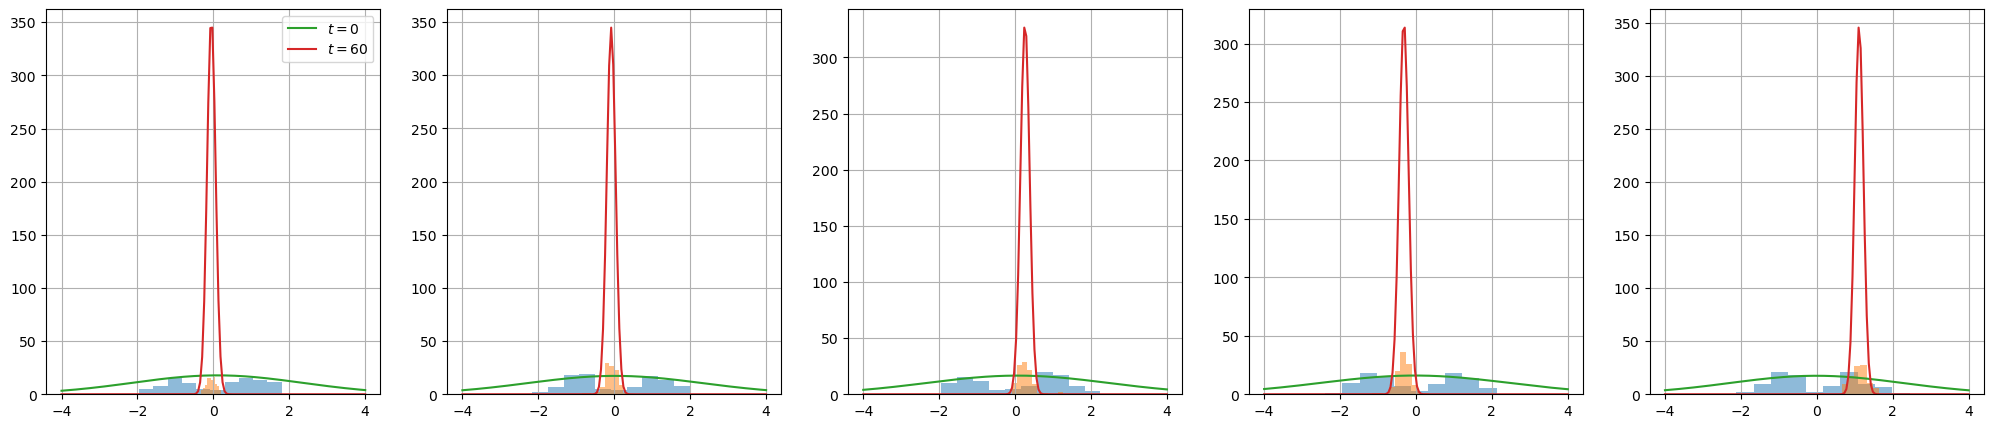

In [12]:
x = np.linspace(-(d+1)*2,(d+1)*2,150)

fig, ax = plt.subplots(1,Ns, figsize = (Ns*5, 5))

for i, a in enumerate(ax):

    a.hist(mus[i,0,:], bins = n_bins, alpha = 0.5)
    a.hist(mus[i,t,:], bins = n_bins, alpha = 0.5)

    gauss0 = Na*norm.pdf(x, loc = mus[i,0,:].mean(), scale = power_law(0, dist = mus[i,0,:].std()))
    gausst = Na*norm.pdf(x, loc = mus[i,t,:].mean(), scale = power_law(t, dist = mus[i,0,:].std()))

    a.plot(x,gauss0, '-', label = '$t = 0$')
    a.plot(x,gausst, '-', label = '$t = $' + str(t))

    a.grid(True)

ax[0].legend()
print(mus[i,t,:].std())
print(power_law(t, dist = mus[i,0,:].std()))
plt.show()

**Check standard deviation prediction**

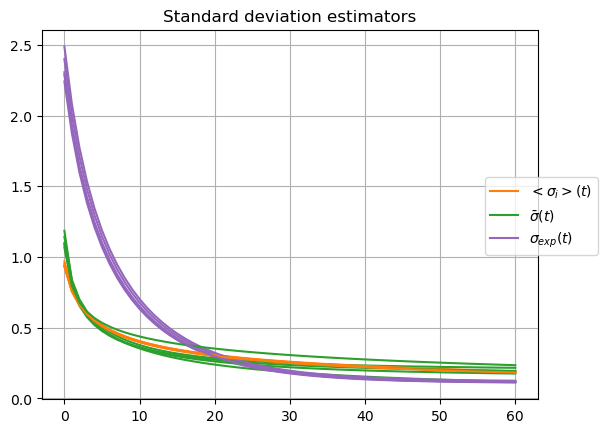

In [13]:
fig, axs = plt.subplots()

x = [t for t in range(0,61)]

stds = np.sqrt(sigmas)

# Compare average agent vdifferent model variances
for i, s in enumerate(stds.mean(axis = 2)):

    y = [power_law(t, dist = mus[i,0,:].std()) for t in x]

    if i == 0:
        axs.plot(s, '-',  color = 'C1', label = '$<\\sigma_{i}>(t)$')
        axs.plot(x, mus[i,x,:].std(axis = -1), color = 'C2', label = '$\\bar{\\sigma}(t)$')
        axs.plot(x, y, color = 'C4', label = '$\\sigma_{exp}(t)$')
    else:
        axs.plot(s, '-',  color = 'C1')
        axs.plot(x, mus[i,x,:].std(axis = -1), color = 'C2')
        axs.plot(x, y, color = 'C4')

axs.grid(True)
axs.set_title('Standard deviation estimators')
fig.legend(loc = 'center right')
plt.show()